In [1]:
# Load all the libraries needed for the projecct as well as provide user agent information
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import sys
import time
import requests
import re 
import random
import itertools
import warnings 
import csv 
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, roc_curve, mean_squared_error
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor 
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from nltk.stem.porter import PorterStemmer
import gradio as gr

headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

In [ ]:
# Get links for 1000 most popular perfumes on fragrantica and add them to a list
product_links = []

def scrape_products(url):
    # Launch the Chrome browser
    driver = webdriver.Chrome()
    base_url = url
    global product_links
    
    try:
        # Open the URL
        driver.get(base_url)
        
        # Click the "Show more results" button repeatedly until all products are loaded
        while True:
            try:
                button = WebDriverWait(driver, 30).until(
                    EC.element_to_be_clickable((By.XPATH, r'//*[@id="main-content"]/div[1]/div[1]/div/div/div/div[2]/div[1]/div/div[3]/div/div/div/div/button')))
                time.sleep(2)  # Add a delay to allow products to load
                driver.execute_script("arguments[0].scrollIntoView(true);", button)
                if not button.is_enabled():
                    print("Button is disabled. Exiting loop.")
                    break
                else:
                    button.click()
            except Exception as e:
                print(f"Exception encountered: {e}")
                break  # Break out of the loop if the button is not found or cannot be clicked anymore
        
        # Wait 10 seconds for the page to load after clicking the button
        time.sleep(10) 
        
        # Get the page source
        page_source = driver.page_source
        
        # Parse the updated page source using BeautifulSoup
        soup = BeautifulSoup(page_source, 'html.parser')
        
        # Get the links and add them to a list
        product_list = soup.find_all('div', class_='card-section')
        for item in product_list:
            for link in item.find_all('a', href=True):
                product_links.append(link['href'])
        
        #Check how many links has been collected
        print(len(product_links))
   
    finally:
        # Close the browser window
        driver.quit()

In [ ]:
# Provide source and execute scrape_products function on fragrantica
fragrantica = 'https://www.fragrantica.com/search/'
scrape_products(fragrantica)

In [34]:
# Create a CSV file for the links
header= ['Link','Name', 'Brand', 'Gender', 'Top_Notes', 'Mid_Notes', 'Base_Notes', 'Rating', 'Year', 'Category', 'Longevity']

with open ('perfume_link.csv', 'w', newline='', encoding= 'UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for link in product_links:
        writer.writerow([link,'','','','','','','','','',''])

#Create CSV file for the dataset
header= ['Link','Name', 'Brand', 'Gender', 'Top_Notes', 'Mid_Notes', 'Base_Notes', 'Rating', 'Year', 'Category', 'Longevity']

with open ('Perfume_dataset.csv', 'w', newline='', encoding= 'UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)

In [105]:
def scrape_perfume(driver, link):
    row=[None]*11
    row[0] = link
    
    driver.get(link)
    data = driver.page_source
    y = BeautifulSoup(data, 'html.parser')
    
    # Extract name and brand
    name_brand = y.find('div', itemprop="description")
    n = name_brand.find_all('b')
    row[1] = n[0].get_text().strip()
    row[2] = n[1].get_text().strip()
    
    # Extract gender
    gender = y.find('h1', itemprop="name").text
    row[3] = gender.split("for")[1].strip()
    
    # Extract notes
    notes = y.find('div', id="pyramid")
    if notes:
        texts = [div.get_text() for div in notes]
        text_string = ' '.join(texts)
    
        if "Top Notes" in text_string:
            top = text_string.split("Top Notes")[1].split("Middle Notes")[0].strip()
            row[4] = ', '.join(re.findall(r'([A-Z][a-z]+(?: [A-Z][a-z]+)*)', top))
        if "Middle Notes" in text_string:
            mid = text_string.split("Middle Notes")[1].split("Base Notes")[0].strip()
            row[5] = ', '.join(re.findall(r'([A-Z][a-z]+(?: [A-Z][a-z]+)*)', mid)).strip()
        if "Base Notes" in text_string:
            base = text_string.split("Base Notes")[1].replace("Vote for Ingredients", "")
            row[6] = ', '.join(re.findall(r'([A-Z][a-z]+(?: [A-Z][a-z]+)*)', base)).strip()
        else:
            match = re.findall(r"/notes/([^/]+)", str(y))
            base =[]
            if match:
                for x in match:
                    if 'span' in x:
                        base.append(' '.join(x.split('.')[0].split('-')[:-1]))
                        row[6] = ', '.join(base).strip()
                            
    else:
        pass
    
    # Extract rating
    row[7] = y.find('span', itemprop="ratingValue").text.strip()
    
    # Extract launch year
    extract_year = y.find_all('div', class_="cell small-12")
    for text in extract_year:
        text = text.get_text()
        match = re.search(r'launched in (\d+)', text)
        if match:
            row[8] = match.group(1).strip()
            break
    
    # Extract category
    categories_list = ["warm spicy", "sweet", "musky", "woody", "aromatic", "floral", "citrus", "aquatic", "green", "fruity"]
    types = y.find_all('div', class_='accord-bar')
    for category in types:
        category = category.get_text().strip()
        if category in categories_list:
            row[9] = "gourmand" if category == "sweet" else category
            break
    
    # Calculate longevity
    longevity_rates = y.find_all('div', class_='cell small-1 medium-1 large-1')
    
    longevity_cal = [0, 0]
    for x in range(5):
        rate = longevity_rates[x].get_text()
        longevity_cal[0] += int(rate) * (x + 1)
        longevity_cal[1] += int(rate)
    
    row[10] = round(longevity_cal[0] / longevity_cal[1], 3)

    driver.quit()

    return row

In [55]:
# Store link that was scraped in this session 
track_link= []

# Count how many data has been collected so far 
csv_file_path = r'Perfume_dataset.csv'
with open(csv_file_path, 'r', newline='', encoding='utf-8') as f:
    csv_reader = csv.reader(f)
    count_data = 0 #Change to 1
    for row in csv_reader:
        if row[1]!= '':
            count_data +=1
        print(row[10])

In [ ]:
# Go through the links and extract the data needed
error_count = 0
data = None 
tally = 0

# Read the links:
with open('perfume_link.csv', 'r', newline='', encoding='UTF8') as f:
    csv_reader = csv.reader(f)
    rows = list(csv_reader)
    
with open('Perfume_dataset.csv', 'r', newline='', encoding='UTF8') as f:
    csv_reader = csv.reader(f)
    existed = list(csv_reader)

for row in rows:
        
    if data != None and 'fragrance' not in data:
        time.sleep(600)
        error_count += 1
        print(error_count)
        
        if error_count == 4:  # ChecK if this is the third consecutive error page
            time.sleep(3000)
            print(f"Second if executed. data count {count_data}. Error count {error_count}")
        elif error_count ==5:
            print("Too many consecutive errors, breaking the loop.")
            break
            
        driver = webdriver.Firefox()
        driver.get(link)
        data = driver.page_source
        driver.quit()

    else:
        # Add rows to CSV file
        with open('Perfume_dataset.csv', 'a', newline='', encoding='UTF8') as f:
            writer = csv.writer(f)
            
            try:
                link = row[0]
                if link not in str(existed) and link not in track_link:
                    # Scrape data from each product page
                    if tally in range(10):
                        driver = webdriver.Firefox()
                        tally+=1
                    elif tally in range(20):
                        driver = webdriver.Edge()
                        tally+=1
                    elif tally in range(30):
                        driver = webdriver.Chrome()
                        tally+=1
                        if tally == 29:
                            tally = 0

                    # Scrape data with function defined above 
                    row = scrape_perfume(driver,link)
                        
                    # Write to CSV
                    writer.writerow(row)
                    
                    track_link.append(link)
                    count_data += 1
                    error_count = 0

                    # Pause after every 3 products
                    if count_data % 3 == 0:
                        time.sleep(30)
                    
                    print(row[1], f' Count: {count_data -1}')

            except Exception as e:
                print(f"An error occurred: {e}")
                driver.quit()
                continue

In [3]:
# Create a list containing links of perfumes that have already been scraped
links = []

# Load the CSV file into a DataFrame
file_path = 'Perfume_dataset.csv'  
df = pd.read_csv(file_path)

# Check for duplicate rows
duplicates = df[df.duplicated()]

# Print the duplicate rows
if not duplicates.empty:
    print("Duplicate rows found:")
    print(duplicates)
else:
    print("No duplicate rows found.")

# Append link of existed perfumes into list
for x in df['Link']:
    links.append(x)


Duplicate rows found:
                                                   Link  \
54    https://www.fragrantica.com/perfume/Louis-Vuit...   
55    https://www.fragrantica.com/perfume/Prada/Prad...   
56    https://www.fragrantica.com/perfume/Giorgio-Ar...   
57    https://www.fragrantica.com/perfume/Mancera/Re...   
58    https://www.fragrantica.com/perfume/Jean-Paul-...   
1005  https://www.fragrantica.com/perfume/Dior/Miss-...   
1006  https://www.fragrantica.com/perfume/Roja-Dove/...   

                                Name               Brand         Gender  \
54                       Imagination       Louis Vuitton            men   
55                     Prada L'Homme               Prada            men   
56                      Acqua di Gio      Giorgio Armani            men   
57                       Red Tobacco             Mancera  women and men   
58                           Le Male  Jean Paul Gaultier            men   
1005   Miss Dior Absolutely Blooming                Dio

In [13]:
#Perform scraping one more time to get missing values
error_count = 0
data = None 
tally = 0
count_data=0

# Read the links:
with open('perfume_link.csv', 'r', newline='', encoding='UTF8') as f:
    csv_reader = csv.reader(f)
    rows = list(csv_reader)
    
with open('Perfume_dataset.csv', 'r', newline='', encoding='UTF8') as f:
    csv_reader = csv.reader(f)
    existed = list(csv_reader)

for row in rows[1:]:
        
    if data != None and 'fragrance' not in data:
        time.sleep(600)
        error_count += 1
        print(error_count)
        
        if error_count == 4:  # ChecK if this is the third consecutive error page
            time.sleep(3000)
            print(f"Second if executed. data count {count_data}. Error count {error_count}")
        elif error_count ==5:
            print("Too many consecutive errors, breaking the loop.")
            break
            
        driver = webdriver.Firefox()
        driver.get(link)
        data = driver.page_source
        driver.quit()

    else:
        # Add rows to CSV file
        with open('Perfume_dataset.csv', 'a', newline='', encoding='UTF8') as f:
            writer = csv.writer(f)
            
            try:
                link = row[0]
                if link not in links:
                    # Scrape data from each product page
                    if tally in range(10):
                        driver = webdriver.Firefox()
                        tally+=1
                    elif tally in range(20):
                        driver = webdriver.Edge()
                        tally+=1
                    elif tally in range(30):
                        driver = webdriver.Chrome()
                        tally+=1
                        if tally == 29:
                            tally = 0
                    
                    # Scrape data with function defined above 
                    row = scrape_perfume(driver,link)
                        
                    # Write to CSV
                    writer.writerow(row)
                    
                    track_link.append(link)
                    count_data += 1
                    error_count = 0

                    # Pause after every 3 products
                    if count_data % 3 == 0:
                        time.sleep(30)
                        
                    driver.quit()
                    
                    print(row[1], f'Count: {count_data -1}')

            except Exception as e:
                print(f"An error occurred: {e}")
                driver.quit()
                continue

In [39]:
df = pd.read_csv("perfume dataset final.csv")
df.reset_index(drop=True, inplace=True)
df

,Link,Name,Brand,Gender,Top_Notes,Mid_Notes,Base_Notes,Rating,Year,Category,Longevity,All_Notes,Notes
0,https://www.fragrantica.com/perfume/Lattafa-Pe...,Khamrah,Lattafa Perfumes,women and men,"Cinnamon, Nutmeg, Bergamot","Dates, Praline, Tuberose, Mahonial","Vanilla, Tonka Bean, Amberwood, Myrrh, Benzoin...",4.37,2022.0,gourmand,3.879,"Cinnamon, Nutmeg, Bergamot, Dates, Praline, Tu...","['Cinnamon', 'Nutmeg', 'Bergamot', 'Dates', 'P..."
1,https://www.fragrantica.com/perfume/Jean-Paul-...,Le Male Elixir,Jean Paul Gaultier,men,"Lavender, Mint","Vanilla, Benzoin","Honey, Tonka Bean, Tobacco",4.55,2023.0,gourmand,4.032,"Lavender, Mint, Vanilla, Benzoin, Honey, Tonka...","['Lavender', 'Mint', 'Vanilla', 'Benzoin', 'Ho..."
2,https://www.fragrantica.com/perfume/By-Kilian/...,Angels' Share,By Kilian,women and men,Cognac,"Cinnamon, Tonka Bean, Oak, Hedione","Vanilla, Praline, Sandalwood, Candied Almond",4.38,2020.0,woody,3.774,"Cognac, Cinnamon, Tonka Bean, Oak, Hedione, Va...","['Cognac', 'Cinnamon', 'Tonka Bean', 'Oak', 'H..."
3,https://www.fragrantica.com/perfume/Jean-Paul-...,Le Male Le Parfum,Jean Paul Gaultier,men,Cardamom,"Lavender, Iris","Vanilla, Oriental, Woodsy Notes",4.60,2020.0,warm spicy,3.779,"Cardamom, Lavender, Iris, Vanilla, Oriental, W...","['Cardamom', 'Lavender', 'Iris', 'Vanilla', 'O..."
4,https://www.fragrantica.com/perfume/Xerjoff/XJ...,XJ 1861 Naxos,Xerjoff,women and men,"Lavender, Bergamot, Lemon","Honey, Cinnamon, Cashmeran, Jasmine Sambac","Tobacco Leaf, Vanilla, Tonka Bean",4.51,2015.0,gourmand,4.015,"Lavender, Bergamot, Lemon, Honey, Cinnamon, Ca...","['Lavender', 'Bergamot', 'Lemon', 'Honey', 'Ci..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,https://www.fragrantica.com/perfume/Attar-Coll...,Khaltat Night,Attar Collection,women and men,NaN,NaN,"Cinnamon, Cherry, Vanilla, Red Apple, Patchoul...",4.21,2016.0,warm spicy,3.719,"Cinnamon, Cherry, Vanilla, Red Apple, Patchoul...","['Cinnamon', 'Cherry', 'Vanilla', 'Red Apple',..."
996,https://www.fragrantica.com/perfume/Azzaro/Chr...,Chrome,Azzaro,men,"Lemon, Rosemary, Bergamot, Neroli, Pineapple","Jasmine, Oakmoss, Cyclamen, Coriander","Musk, Oakmoss, Cedar, Sandalwood, Cardamom, Br...",3.93,1996.0,citrus,3.180,"Lemon, Rosemary, Bergamot, Neroli, Pineapple, ...","['Lemon', 'Rosemary', 'Bergamot', 'Neroli', 'P..."
997,https://www.fragrantica.com/perfume/Diptyque/T...,Tam Dao Eau de Parfum,Diptyque,women and men,NaN,NaN,"Sandalwood, Cedar, Amberwood, Coriander, Musk,...",4.13,2013.0,woody,3.042,"Sandalwood, Cedar, Amberwood, Coriander, Musk,...","['Sandalwood', 'Cedar', 'Amberwood', 'Coriande..."
998,https://www.fragrantica.com/perfume/Dior/Miss-...,Miss Dior Absolutely Blooming,Dior,women,"Raspberry, Black Currant, Pomegranate, Pink Pe...","May Rose, Peony",White Musk,4.02,2016.0,fruity,3.677,"Raspberry, Black Currant, Pomegranate, Pink Pe...","['Raspberry', 'Black Currant', 'Pomegranate', ..."


In [61]:
#Remove duplicates 
df=df.drop_duplicates()

In [ ]:
# Inspecting the dataset 
# Column 'Gender'
df['Gender'].unique() #There are some errors in the values 

In [36]:
# Reclassifying the records that contains error values using keywords
men = ['Men', 'Him']
women = ['Women','Her']
for row, gender in enumerate(df['Gender']):
    if gender not in ['women and men', 'men', 'women']:
        for i in gender.split(' '):
            if i in men:
                df.loc[row,'Gender'] = 'men'
            elif i in women:
                df.loc[row,'Gender'] = 'women'
            else:
                df.loc[row,'Gender'] = 'women and men'
                
df['Gender'].unique()

array(['women and men', 'men', 'women'], dtype=object)

In [78]:
missing_values = df.isnull().sum()
missing_values

Link            0
Name            0
Brand           0
Gender          0
Top_Notes     115
Mid_Notes     118
Base_Notes      0
Rating          0
Year           25
Category        0
Longevity       0
dtype: int64

In [4]:
# Find rows with missing values
rows_with_missing_values = df[df.isnull().any(axis=1)]

# Print the rows with missing values
print(rows_with_missing_values)

                                                  Link                   Name  \
15   https://www.fragrantica.com/perfume/Giardini-D...           Bianco Latte   
54   https://www.fragrantica.com/perfume/Initio-Par...            Side Effect   
55   https://www.fragrantica.com/perfume/Essential-...          Bois Impérial   
61   https://www.fragrantica.com/perfume/Tom-Ford/O...               Oud Wood   
74   https://www.fragrantica.com/perfume/Sol-de-Jan...           Cheirosa '62   
..                                                 ...                    ...   
959  https://www.fragrantica.com/perfume/Le-Labo/Be...           Bergamote 22   
966  https://www.fragrantica.com/perfume/Maison-Mar...      Afternoon Delight   
976  https://www.fragrantica.com/perfume/Nasomatto/...                Blamage   
995  https://www.fragrantica.com/perfume/Attar-Coll...          Khaltat Night   
997  https://www.fragrantica.com/perfume/Diptyque/T...  Tam Dao Eau de Parfum   

                      Brand

In [76]:
with open("perfume dataset final.csv", "w") as file:
    pass  #clear the file 

# Write new data into the emptied file
df.to_csv("perfume dataset final.csv", index=False)

In [ ]:
#Perform EDA on the dataset 

In [98]:
gender_category_counts

Category,aquatic,aromatic,citrus,floral,fruity,gourmand,green,musky,warm spicy,woody
Gender,,,,,,,,,,
men,2,65,65,1,9,23,5,2,38,46
women,2,4,44,51,44,81,5,20,20,27
women and men,3,29,55,15,37,93,9,32,70,103


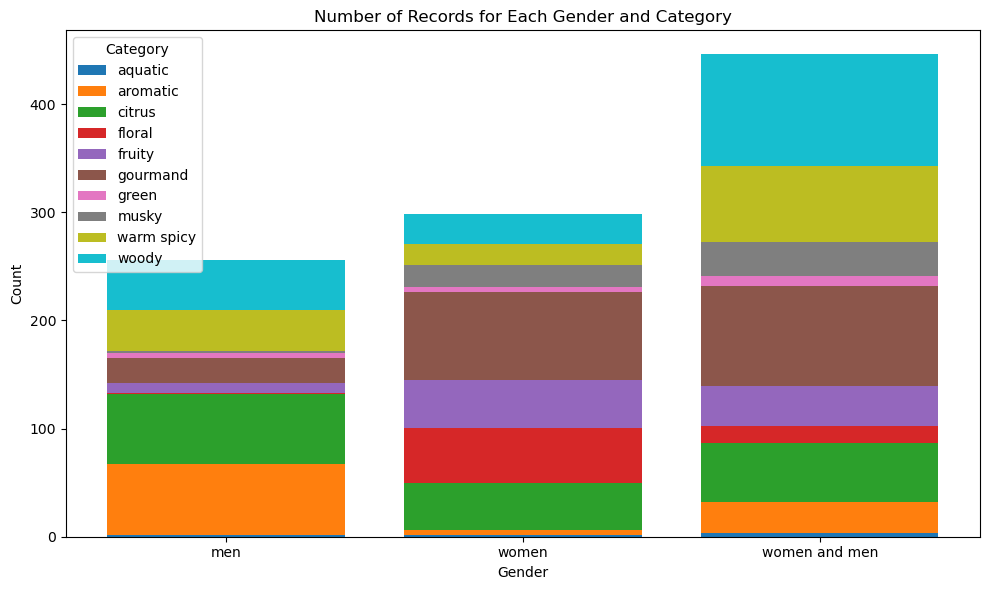

In [87]:
# Count occurrences of each category for each gender
gender_category_counts = df.groupby(['Gender', 'Category']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(10, 6))
x = np.arange(len(gender_category_counts.index))  # X-axis positions for genders

# Plot each category as a stacked bar
bottom = np.zeros(len(gender_category_counts))
for category in gender_category_counts.columns:
    plt.bar(x, gender_category_counts[category], bottom=bottom, label=category)
    bottom += gender_category_counts[category]  # Update the bottom for stacking

# Add labels and legend
plt.title('Number of Records for Each Gender and Category')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(x, gender_category_counts.index, rotation=0)
plt.legend(title='Category')
plt.tight_layout()
plt.show()


In [ ]:
#Men has significantly more aromatic perfume compare to bth women and unisex
#Men has no floral, musk and significantly less gourmand perfume 
#Aquatic and green are not that popular at the time that this data was collected 

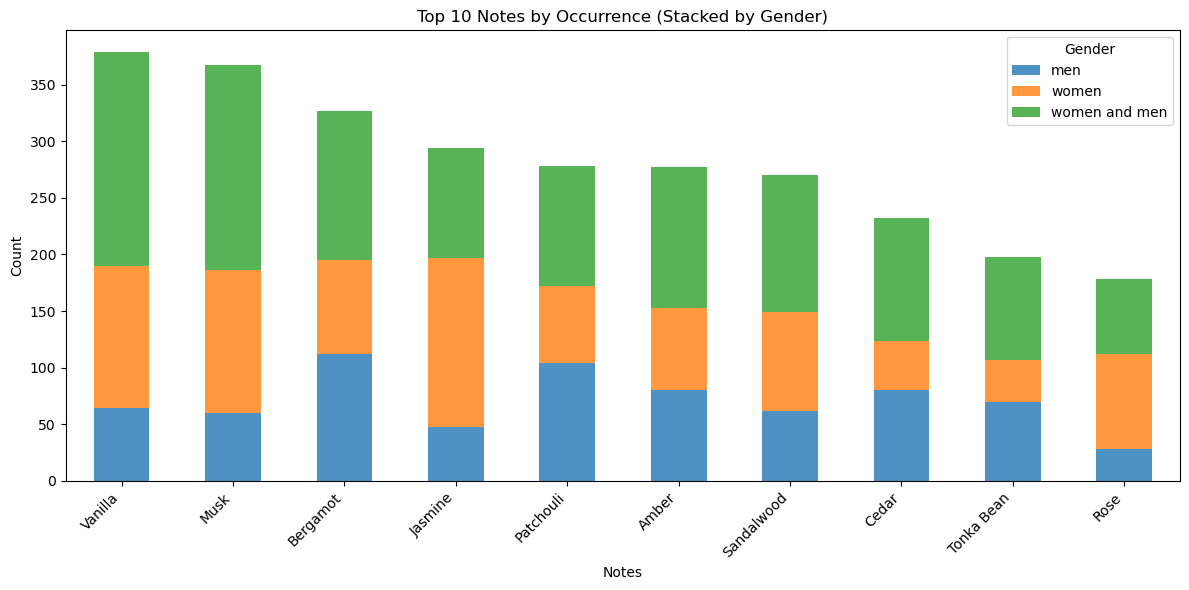

In [10]:
# Combine all notes into a single column
df['All_Notes'] = df["Top_Notes"] + ", " + df["Mid_Notes"] + ", " + df["Base_Notes"]
for row in df.iterrows():
    if pd.isna(row[1]['Top_Notes']) and pd.isna(row[1]['Mid_Notes']):
        df.loc[row[0],'All_Notes'] = df.loc[row[0]]['Base_Notes']
    elif pd.isna(row[1]['Mid_Notes']):
        df.loc[row[0],'All_Notes'] = df.loc[row[0]]['Top_Notes'] + df.loc[row[0]]['Base_Notes']

# Split all the notes
df["Notes"] = df["All_Notes"].str.split(", ")
exploded_df = df.explode("Notes")[["Gender", "Notes"]]

# Count occurrences of notes by gender
note_counts_by_gender = exploded_df.groupby(["Notes", "Gender"]).size().unstack(fill_value=0)

# Calculate total counts of each note
note_counts_by_gender["Total"] = note_counts_by_gender.sum(axis=1)

# Get the top 10 notes by total count
top_notes = note_counts_by_gender.nlargest(10, "Total")

# Plotting the stacked bar chart
top_notes.drop(columns="Total").plot(kind = "bar", stacked=True, figsize=(12, 6), alpha=0.8)

plt.title("Top 10 Notes by Occurrence (Stacked by Gender)")
plt.xlabel("Notes")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

In [93]:
# The most popular note at the moment is vanilla
# Musky perfume is not popular with men but they do prefer the note "musk" in their perfume 
# The most popular note for women is jasmine, men is bergamot, unisex is vanilla 

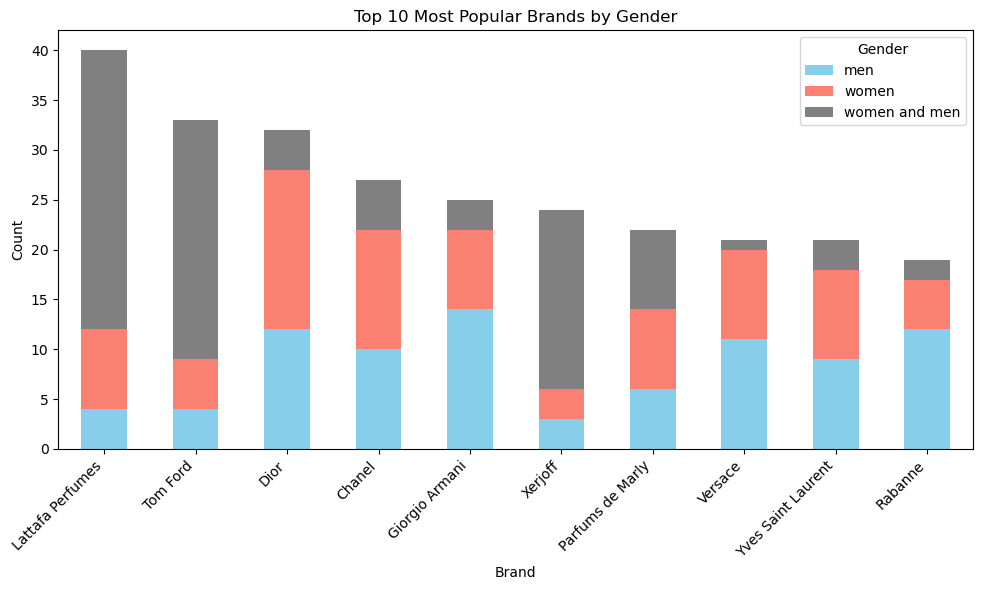

In [129]:
# Group by Brand and Gender, then count occurrences
brand_gender_counts = df.groupby(['Brand', 'Gender']).size().unstack(fill_value=0)

# Select the top 10 most popular brands
top_10_brands = brand_gender_counts.sum(axis=1).nlargest(10).index

# Filter the DataFrame to include only the top 10 brands
brand_gender_counts_top_10 = brand_gender_counts.loc[top_10_brands]

# Plotting the stacked bar chart
ax = brand_gender_counts_top_10.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon','gray'])

plt.title('Top 10 Most Popular Brands by Gender')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Count the number of perfumes for each brand
brand_counts = df.groupby('Brand').size()

# Filter brands that have more than 4 perfumes
valid_brands = brand_counts[brand_counts > 4].index

# Filter the original DataFrame to only include rows from valid brands (brands that appear more than 4 times in the dataset)
filtered_df = df[df['Brand'].isin(valid_brands)]

# Group by 'Brand' and calculate the mean rating for each brand
brand_ratings = filtered_df.groupby('Brand')['Rating'].mean()

# Sort brands by their average rating in descending order
brand_ratings = brand_ratings.sort_values(ascending=False)

# Display the ranked brands
print(brand_ratings)


Models 

In [ ]:
# Predict gender, identify target customer segments
# Usually developers already have a target gender for their perfume but this model is used to see how other groups may react to the perfume 

In [11]:
# Create a list of notes
notes = df['All_Notes'].tolist()

# Build a vocabulary of notes 
vectorizer = CountVectorizer(binary = True, max_features = 1000).fit(notes)

# Create a df with notes 
bag_of_notes = vectorizer.transform(notes)
df_notes = pd.DataFrame(bag_of_notes.toarray())
note_name = vectorizer.get_feature_names_out().tolist()
df_notes.columns = [i for i in note_name]

# Create dummy variables for the 'Brand' column
df_brand = pd.get_dummies(df['Brand'], prefix='Brand')

# Create dummy variables for the 'Category' column
df_category = pd.get_dummies(df['Category'], prefix='Category')

# Create a df with all relevant variables 
combined_df = pd.concat([df['Gender'],df_brand,df_category, df_notes], axis=1)

print(combined_df)

            Gender  Brand_4711  Brand_Abercrombie & Fitch  \
0    women and men       False                      False   
1              men       False                      False   
2    women and men       False                      False   
3              men       False                      False   
4    women and men       False                      False   
..             ...         ...                        ...   
995  women and men       False                      False   
996            men       False                      False   
997  women and men       False                      False   
998          women       False                      False   
999            men       False                      False   

     Brand_Acqua di Parma  Brand_Afnan  Brand_Akro  \
0                   False        False       False   
1                   False        False       False   
2                   False        False       False   
3                   False        False       False 

In [187]:
#Split df into training and testing dataset
training_df, testing_df = train_test_split(combined_df, test_size=0.2, random_state=42)

X_train = training_df.drop(columns=['Gender'])
y_train = training_df.Gender

X_test = testing_df.drop(columns=['Gender'])
y_test = testing_df.Gender

#Create the model 
clf = RandomForestClassifier(n_estimators = 100, random_state=3).fit(X_train,y_train)

# Assumming false positive and false negative yield the same cost, we will measure model performance using accuracy rate
# Training accuracy
print('Random Forest Classification Training Accuracy %:', round(clf.score(X_train, y_train) * 100, 4))

# Testing accuracy
print('Random Forest Classification Testing Accuracy %:', round(float(accuracy_score(clf.predict(X_test), y_test)) * 100, 4))

Random Forest Classification Training Accuracy %: 100.0
Random Forest Classification Testing Accuracy %: 74.5


In [189]:
# Explore what features are most important 
feature_importance = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_importance.head(10)

jasmine            0.029812
lavender           0.017445
rose               0.013263
blossom            0.013003
Category_floral    0.012250
sage               0.011842
vetiver            0.011450
musk               0.011291
patchouli          0.011220
vanilla            0.011117
dtype: float64

In [ ]:
# Use user's prefer notes/ favorite perfume as predictors in the K-nearest neighbors model to recommend perfumes to users

In [55]:
# Initialize a CountVectorizer to convert text data into a matrix of token counts
po = PorterStemmer()
cv = CountVectorizer(stop_words='english')

# Transform the 'All_Notes' column into a numerical array using CountVectorizer
notes_array = cv.fit_transform(df['All_Notes']).toarray()

# Initialize the NearestNeighbors model with cosine similarity as the distance metric, 'brute' algorithm is used for exhaustive search
model = NearestNeighbors(metric='cosine',algorithm='brute')
model.fit(notes_array)

NearestNeighbors(algorithm='brute', metric='cosine')

In [122]:
# Recommend perfumes based on user's favorite perfumes
# Ask user for their favorite perfume name
favorite_perfume = input("What's your favorite perfume? ")

def rec_by_perfume(favorite_perfume):
    # Find the row where the name matches the input
    favorite_note = df.loc[df['Name'].str.lower() == favorite_perfume.lower(), 'All_Notes']
    
    # If the perfume is in the dataset, output recommenations, otherwise, say that the perfume is not in the dataset
    if not favorite_note.empty:
        transformed_note = cv.transform([favorite_note.iloc[0]]).toarray()
        distances, indices = model.kneighbors(transformed_note,n_neighbors=6)
        return list(df['Name'][indices[0][1:]].values)

rec_by_perfume(favorite_perfume)

What's your favorite perfume?  intense cafe


['Ristretto Intense Café',
 'Rose Gourmand For Her',
 'Oud Mood',
 'Delina La Rosée',
 'Ajwad']

In [10]:
df[(df.Name == "Intense Cafe")]

,Link,Name,Brand,Gender,Top_Notes,Mid_Notes,Base_Notes,Rating,Year,Category,Longevity,All_Notes,Notes
167,https://www.fragrantica.com/perfume/Montale/In...,Intense Cafe,Montale,women and men,Floral Notes,"Rose, Coffee","Vanila, White Musk, Amber",3.97,2013.0,floral,4.011,"Floral Notes, Rose, Coffee, Vanila, White Musk...","['Floral Notes', 'Rose', 'Coffee', 'Vanila', '..."


In [123]:
# Recommend perfumes based on user's favorite notes, I will use the notes from the perfume above to see if the models give the same recommendation
favorite_note = input("What notes are you looking for in your perfume? ")

def rec_by_notes(favorite_note):
    # Transform the notes to put in the model
    transformed_note = cv.transform([favorite_note]).toarray()
    distances, indices = model.kneighbors(transformed_note,n_neighbors=5)
    return list(df['Name'][indices[0][:]].values)

rec_by_notes(favorite_note)

What notes are you looking for in your perfume?  Floral Notes, Rose, Coffee, Vanila, White Musk


['Intense Cafe',
 'Ristretto Intense Café',
 'Delina La Rosée',
 'Chance Eau Tendre Eau de Parfum',
 'Oud Mood']

In [114]:
# Recommend perfumes based on user's favorite perfumes (with link)
# Ask user for their favorite perfume name
favorite_perfume_link = input("What's the link your favorite perfume? ")

def rec_by_perfume_link(favorite_perfume_link):
    if not df[(df.Link==favorite_perfume_link)].empty:
        favorite_note = df[(df.Link==favorite_perfume_link)]['All_Notes'].iloc[0]
    else:
        # Scrape data
        driver = webdriver.Chrome()
        row = scrape_perfume(driver, favorite_perfume_link)
        if row[4] is None and row[5] is None:
            favorite_note = row[6]
        elif row[4] is None:
            favorite_note = row[5] +', '+ row[6]
        elif row[5] is None:
            favorite_note = row[4] +', '+ row[6]
    
    # If the perfume is in the dataset, output recommenations, otherwise, say that the perfume is not in the dataset
    if favorite_note:
        transformed_note = cv.transform([favorite_note]).toarray()
        distances, indices = model.kneighbors(transformed_note,n_neighbors=6)
        return list(df['Name'][indices[0][1:]].values), row

rec_by_perfume_link(favorite_perfume_link)

What's the link your favorite perfume?  https://www.fragrantica.com/perfume/Imaginary-Authors/Sundrunk-51312.html


Suggested similar perfumes: ["Love Don't Be Shy", 'Noir Extreme', 'Essenza di Colonia', 'Poison Girl', "Chanel No 5 L'Eau"]


In [130]:
def recommend_perfumes(search_method, search_input):
    # Handle search based on the selected method
    if search_method == "Notes":
        recommendations = rec_by_notes(search_input)
    elif search_method == "Perfume Name":
        recommendations = rec_by_perfume(search_input)
    elif search_method == "Link":
        recommendations = rec_by_perfume_link(search_input)[0]
    else:
        recommendations = ["Invalid search method selected."]
    
    # Return the recommendations
    if len(recommendations) == 0:
        return ["No matching perfumes found."]
    return ', '.join(recommendations)

# Define the Gradio interface
interface = gr.Interface(
    fn=recommend_perfumes,
    inputs=[gr.Dropdown(choices=["Notes", "Perfume Name", "Link"], label="Search By"), gr.Textbox(label="Search Input")],
    outputs=gr.Textbox(label="Recommended Perfumes"),
    title="Perfume Recommender",
    description="Search for perfumes by their notes, name, or link.")

# Launch the interface
interface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7878
* Running on public URL: https://b64fb40a232fa4cfab.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [198]:
# Create dummy variables for column Gender
df_gender = pd.get_dummies(df['Gender'], prefix='Gender')

# Create a dataset use for model that predict perfume's longevity
longevity_df = pd.concat([df['Longevity'],combined_df.drop(columns='Gender'), df_gender], axis=1)

#Split df into training and testing dataset
training_df, testing_df = train_test_split(longevity_df, test_size=0.2, random_state=42)

X_train = training_df.drop(columns=['Longevity'])
y_train = training_df.Longevity

X_test = testing_df.drop(columns=['Longevity'])
y_test = testing_df.Longevity

In [210]:
# Create the model using optimal n_estimators
params = {'n_estimators': 250, 'max_depth': 2, 'learning_rate': 0.1, 'criterion': 'friedman_mse'}
gbr = GradientBoostingRegressor(**params)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=250)

In [211]:
# Make predictions on the training data
y_pred_train = gbr.predict(X_train)

# Make predictions on the test set
y_pred_test = gbr.predict(X_test)

# Calculate Mean Squared Error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Mean Squared Error on training data: {mse_train}")
print(f"Mean Squared Error on testing data: {mse_test}")


Mean Squared Error on training data: 0.06720532500747009
Mean Squared Error on testing data: 0.11196594851033041


In [194]:
# Explore what features are most important 
feature_importance = pd.Series(gbr.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_importance.head(10)

oud                             0.068290
patchouli                       0.051562
Gender_women                    0.037935
Category_warm spicy             0.033351
Brand_Sol de Janeiro            0.026739
Brand_Maison Martin Margiela    0.023098
Category_citrus                 0.022347
Brand_4711                      0.021433
saffron                         0.019429
vanilla                         0.019007
dtype: float64